In [1]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import pickle

import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 





In [2]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [3]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/cnn_kernel_check/")
SAVE_DIR = os.path.join(CODE_DIR, "simple_cnn_models/")

In [4]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



if not os.path.exists(SAVE_DIR):
    # Create the directory
    os.makedirs(SAVE_DIR)
    print(f"Directory '{SAVE_DIR}' was created.")
else:
    print(f"Directory '{SAVE_DIR}' already exists.")

Directory '/home/jenny/evidence-chain/figs/cnn_kernel_check/' already exists.
Directory '/home/jenny/evidence-chain/simple_cnn_models/' already exists.


In [5]:
stimdur = '250'
pos=8
evaluate_mode = False

In [6]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_84077/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_84077/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_84077/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [7]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [8]:
df.shape

(3400, 13)

In [9]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [10]:
count.max()

29

In [11]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [12]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [13]:
dataset, dataset_resp = make_dataset(pos, count, chain_matrix)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.3, random_state=2024
)
x_train, x_val, y_train, y_val = train_test_split(
x_train_val, y_train_val, test_size=0.25, random_state=1
)

In [14]:
x_train.shape

(672, 9)

In [15]:
# x_train = get_evidence(x_train)
# x_val = get_evidence(x_val)
# x_test = get_evidence(x_test)

In [16]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors and create datasets
def create_dataset(x, y):
    x_tensor = torch.Tensor(x).unsqueeze(1)  # Add channel dimension
    y_tensor = torch.Tensor(y).unsqueeze(1)
    y_tensor = y_tensor.type(torch.float32)  # Convert boolean labels to float for BCELoss
    return TensorDataset(x_tensor, y_tensor)

# Create datasets
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)
train_val_dataset = create_dataset(x_train_val, y_train_val)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_val_loader= DataLoader(train_val_dataset, batch_size=batch_size)


x_train.shape

In [17]:

# Define the model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=4, stride=1, padding=0)  # output is N x 16 x 5
        self.fc1 = nn.Linear(1, 1,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        # x = torch.relu(x)
        x, max_ind= torch.max(x[:,:,-2:], 2)  # Global average pooling
        # print(max_ind)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [18]:
# Training and Evaluation Loops
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        if len(targets) == 1:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # model.fc1.apply(clipper)
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            if len(targets) == 1:
                break
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_outputs.extend(outputs.squeeze().cpu().numpy())
            all_targets.extend(targets.squeeze().cpu().numpy())
    return total_loss / len(dataloader), all_outputs, all_targets


In [19]:

if evaluate_mode:
    PATH = f'/home/jenny/evidence-chain/simple_cnn_models/best_pos{pos}_running.pkl'
    model =CNN1D()
    model.load_state_dict(torch.load(PATH))
    model.eval()
    model = model.to(device)


    # Loss function and optimizer
    criterion = nn.BCELoss()


    # Train the model
    num_epochs = 20
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss,_,_ = evaluate(model, train_loader, criterion)
        val_loss, _, _ = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # if epoch % 10 ==0:
        #     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # Evaluate AUC on the test set
    test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion)
    train_loss, train_outputs, train_targets = evaluate(model, train_loader, criterion)

    test_auc = roc_auc_score(test_targets, test_outputs)
    train_auc = roc_auc_score(train_targets, train_outputs)


    print(f'Train Loss: {train_loss}')
    print(f'Train AUC: {train_auc}')



    test_auc = roc_auc_score(test_targets, test_outputs)
    print(f'Test Loss: {test_loss}')
    print(f'Test AUC: {test_auc}')


===================ATTEMP 0======================
Train Loss: 0.3953814534913926
Train AUC: 0.6249539866008982
Test Loss: 0.3007647739006923
Test AUC: 0.643968023255814
saved a better model!


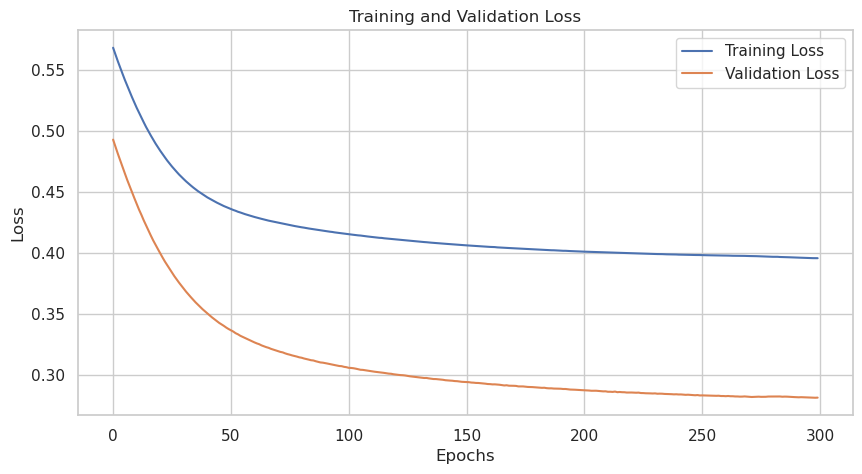

Epoch 1, Train Loss: 0.3637891848539484
Epoch 11, Train Loss: 0.36249232549091864
Epoch 21, Train Loss: 0.36186548091214277
Epoch 31, Train Loss: 0.361433666327904
Epoch 41, Train Loss: 0.3611112920374706
Epoch 51, Train Loss: 0.360867525996833
Epoch 61, Train Loss: 0.3606837155490086
Epoch 71, Train Loss: 0.3605458464088111
Epoch 81, Train Loss: 0.36044292717144405
Epoch 91, Train Loss: 0.36036644156636866
Epoch 101, Train Loss: 0.360309785296177
Epoch 111, Train Loss: 0.36026793358654813
Epoch 121, Train Loss: 0.36023709897337286
Epoch 131, Train Loss: 0.3602144281411993
Epoch 141, Train Loss: 0.3601977727536497
Epoch 151, Train Loss: 0.3601856205997796
Epoch 161, Train Loss: 0.3601767122745514
Epoch 171, Train Loss: 0.3601703705458805
Epoch 181, Train Loss: 0.3601656458501158
Epoch 191, Train Loss: 0.36016202435411254
Epoch 201, Train Loss: 0.36016030455457754
Epoch 211, Train Loss: 0.36015840902410706
Epoch 221, Train Loss: 0.36015707819626247
Epoch 231, Train Loss: 0.3601561455891

In [20]:
num_attempts = 300

if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs = 300
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_1 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_1.parameters(), lr=0.0005)


        # Train the model
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_epoch(model_1, train_loader, criterion, optimizer)
            val_loss, _, _ = evaluate(model_1, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # if epoch % 10 ==0:
            #     print(f'Epoch {epoch+1}, Train Loss: {}, Validation Loss: {val_loss}')



        # Evaluate AUC on the test set
        test_loss, test_outputs, test_targets = evaluate(model_1, test_loader, criterion)
        train_loss, train_outputs, train_targets = evaluate(model_1, train_loader, criterion)

        test_auc = roc_auc_score(test_targets, test_outputs)
        train_auc = roc_auc_score(train_targets, train_outputs)

        print(f"===================ATTEMP {i}======================")

        print(f'Train Loss: {train_loss}')
        print(f'Train AUC: {train_auc}')



        test_auc = roc_auc_score(test_targets, test_outputs)
        print(f'Test Loss: {test_loss}')
        print(f'Test AUC: {test_auc}')

        if test_auc >best_test_auc and train_auc>best_train_auc:
            best_test_auc = test_auc
            best_train_auc = train_auc
            PATH = f'/home/jenny/evidence-chain/simple_cnn_models/best_pos{pos}_running.pkl'
            torch.save(model_1.state_dict(), PATH)
            print("saved a better model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()


            conv_bias = model_1.conv1.bias.data
            weights = model_1.conv1.weight.data
            fc_weights = model_1.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                   mydict[key] = value
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_running.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)

            ## continue training)
    
            train_val_losses = []

            for epoch in range(num_epochs_final):
                train_val_loss = train_epoch(model_1, train_val_loader, criterion, optimizer)
                train_val_losses.append(train_val_loss)
                if epoch % 10 ==0:
                    print(f'Epoch {epoch+1}, Train Loss: {train_val_loss}')



            # Evaluate AUC on the test set
            test_loss_final, test_outputs_final, test_targets_final = evaluate(model_1, test_loader, criterion)
            train_loss_final, train_outputs_final, train_targets_final = evaluate(model_1, train_val_loader, criterion)

            test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
            train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

            print(f"===================ATTEMP {i} final training======================")

            print(f'Train Loss: {train_loss_final}')
            print(f'Train AUC: {train_auc_final}')

            print(f'Test Loss: {test_loss_final}')
            print(f'Test AUC: {test_auc_final}')


            if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
                best_test_auc = test_auc_final
                best_train_auc = train_auc_final
                PATH = f'/home/jenny/evidence-chain/simple_cnn_models/best_pos{pos}_continued.pkl'
                torch.save(model_1.state_dict(), PATH)
                print("saved a better final model!")

                    # # Plot training and validation losses
                plt.figure(figsize=(10, 5))
                plt.plot(train_val_losses, label='Training Loss Final')
                plt.title('Final Training Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                conv_bias = model_1.conv1.bias.data
                weights = model_1.conv1.weight.data
                fc_weights = model_1.fc1.weight.data

                kernel = weights.cpu().numpy()
                fc_bias = fc_weights.cpu().numpy()
                conv_bias = conv_bias.cpu().numpy()
                mydict = {}
                mykeys = ["kernel", "position","fc_bias", "conv_bias"]
                values = [kernel, pos, fc_bias, conv_bias]
                for key, value in zip(mykeys, values):
                    # Here you can add conditions or transformations
                    mydict[key] = value
                # Save the dictionary into a pickle file
                
                FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_continued.pkl")
                with open(FILEPATH, 'wb') as pickle_file:
                    pickle.dump(mydict, pickle_file)



===================ATTEMP 0 final training======================
Train Loss: 0.3654651467142434
Train AUC: 0.5215474858440986
Test Loss: 0.3116331146313594
Test AUC: 0.4899709302325581
saved a better final model!


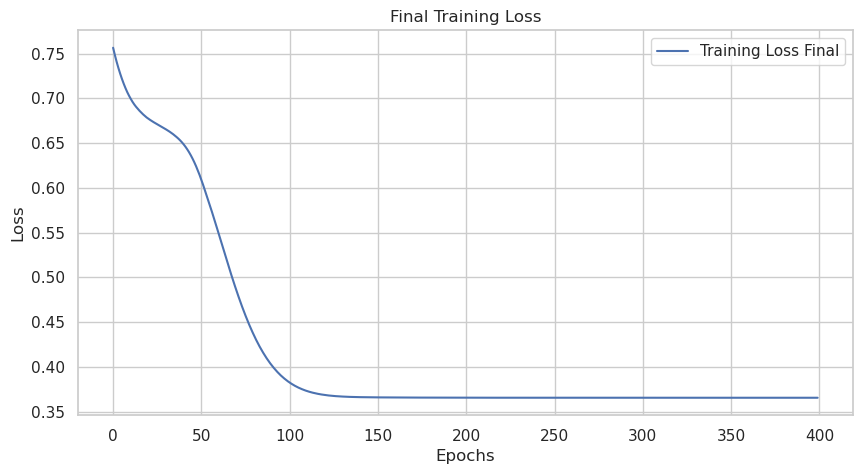

===================ATTEMP 1 final training======================
Train Loss: 0.35603394076741973
Train AUC: 0.6132133048519988
Test Loss: 0.30315014949211705
Test AUC: 0.609484011627907
saved a better final model!


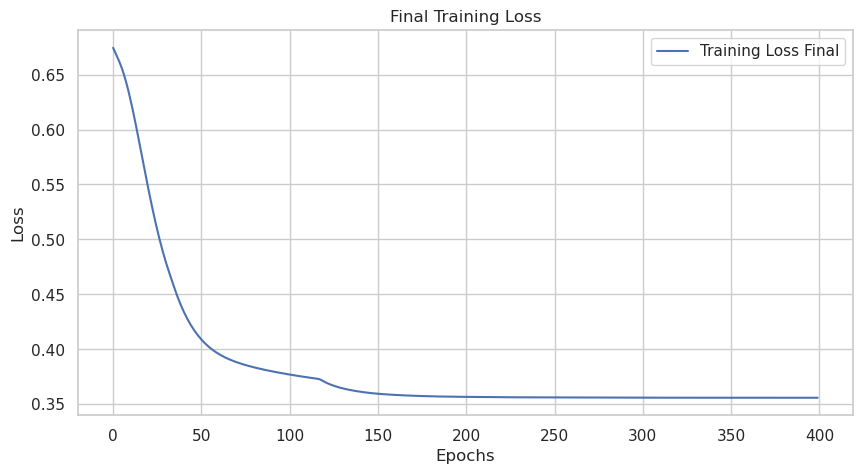

===================ATTEMP 2 final training======================
Train Loss: 0.3654655598360917
Train AUC: 0.5215474858440986
Test Loss: 0.3116342517045828
Test AUC: 0.4899709302325581
===================ATTEMP 3 final training======================
Train Loss: 0.36560283549900713
Train AUC: 0.520112116999514
Test Loss: 0.31012757007892316
Test AUC: 0.4998183139534884
===================ATTEMP 4 final training======================
Train Loss: 0.35603313353554955
Train AUC: 0.6158749533787679
Test Loss: 0.3031639399436804
Test AUC: 0.5984011627906977
===================ATTEMP 5 final training======================
Train Loss: 0.36546502647728757
Train AUC: 0.5215474858440986
Test Loss: 0.31163617510061997
Test AUC: 0.4899709302325581
===================ATTEMP 6 final training======================
Train Loss: 0.3620919996294482
Train AUC: 0.5889420088382554
Test Loss: 0.30562343849585605
Test AUC: 0.5966933139534883
===================ATTEMP 7 final training======================
Train

In [21]:
num_attempts = 300


if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_2 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_2.parameters(), lr=0.0005)



        train_val_losses = []

        for epoch in range(num_epochs_final):
            train_val_loss = train_epoch(model_2, train_val_loader, criterion, optimizer)
            train_val_losses.append(train_val_loss)


        # Evaluate AUC on the test set
        test_loss_final, test_outputs_final, test_targets_final = evaluate(model_2, test_loader, criterion)
        train_loss_final, train_outputs_final, train_targets_final = evaluate(model_2, train_val_loader, criterion)

        test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
        train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

        print(f"===================ATTEMP {i} final training======================")

        print(f'Train Loss: {train_loss_final}')
        print(f'Train AUC: {train_auc_final}')

        print(f'Test Loss: {test_loss_final}')
        print(f'Test AUC: {test_auc_final}')


        if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
            best_test_auc = test_auc_final
            best_train_auc = train_auc_final
            PATH = f'/home/jenny/evidence-chain/simple_cnn_models/best_pos{pos}_final.pkl'
            torch.save(model_2.state_dict(), PATH)
            print("saved a better final model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_val_losses, label='Training Loss Final')
            plt.title('Final Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            conv_bias = model_2.conv1.bias.data
            weights = model_2.conv1.weight.data
            fc_weights = model_2.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                # Here you can add conditions or transformations
                mydict[key] = value
            # Save the dictionary into a pickle file
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_final.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)


In [22]:
model.fc1.weight.data

NameError: name 'model' is not defined

In [ ]:
conv_bias = model.conv1.bias.data

In [ ]:
conv_bias

In [ ]:
weights = model.conv1.weight.data

In [ ]:
weights

In [ ]:
fc_weights = model.fc1.weight.data

In [ ]:
fc_weights

In [ ]:
for w in weights:
    w = w.cpu().numpy().squeeze()
    print(w)
    plt.plot(np.arange(0,4),w,'o-')
    plt.show()

In [ ]:
pos

In [ ]:
kernel = weights.cpu().numpy()
position = pos
fc_bias = fc_weights.cpu().numpy()
conv_bias = conv_bias.cpu().numpy()
mydict = {}
mykeys = ["kernel", "position","fc_bias", "conv_bias"]
values = [kernel, position, fc_bias, conv_bias]
for key, value in zip(mykeys, values):
    # Here you can add conditions or transformations
    mydict[key] = value




# Save the dictionary into a pickle file
FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param.pkl")
with open(FILEPATH, 'wb') as pickle_file:
    pickle.dump(mydict, pickle_file)

In [ ]:
mydict

In [ ]:
PATH = f'/home/jenny/evidence-chain/simple_cnn_models/best_pos{pos},pkl'

# torch.save(model.state_dict(), PATH)
# m =CNN1D()
# m.load_state_dict(torch.load(PATH))
# m.eval()

In [ ]:
m = nn.Conv1d(1, 1, 3, stride=2,bias=False)


In [ ]:
input = torch.tensor([1,2,3],dtype=torch.float32).reshape(1,3)

In [ ]:
m.weight.data

In [ ]:
output = m(input)

In [ ]:
output

In [ ]:
m.weight.data @ input.T

In [ ]:
a = np.array((0.4437, -0.3275, -0.3687))
b = np.array((1,2,3))

In [ ]:
pos